<div style='padding:10px;background-color:rgb(235, 240, 235);'>
Nicholas Brower<br>
Springboard DSCT May-2022<br>
</div>

# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Imports, constants, clases, and functions are defined in the <span style='font-family:monospace'>sb_dsct_21_1_2.py</span> module located in the root directory of this notebook. They are viewable as code cells in a separate notebook <a style='color:rgb(0,0,0);text-decoration: underline'; href='21.1.2 - Constants%2C classes and functions.ipynb'>here</a>.
</div> 

In [1]:
from sb_dsct_21_1_2 import *

### 1b. Load the data
Call the variable `cig_data`. 

In [2]:
cig_data = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cig_data.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

Let's check out the data types of our columns.

In [4]:
print(f'cig_data: {len(cig_data.columns)} columns'
      + f'\n-\n\t{"name":<20}{"dtype":>15}\n\t{"-"*35}')
for name, dtype in zip(cig_data.columns, cig_data.dtypes):
    print(f'\t{name[:20]:<20}{f"{dtype}":>15}')

cig_data: 3 columns
-
	name                          dtype
	-----------------------------------
	Unnamed: 0                    int64
	Time                         object
	#CigSales                     int64


<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Check if the column
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        Unnamed: 0
    </span> is identical to the index.
</div> 

In [5]:
print(all([i == row['Unnamed: 0'] for i, row in cig_data.iterrows()]))

True


Check whether there are any null values. 

In [6]:
print(f'contains null values: {any(cig_data.isnull().sum())}')

contains null values: False


## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [7]:
cig_data.drop(columns='Unnamed: 0', inplace=True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
cig_data.rename(
    columns={'Time':'yyyy_mm', '#CigSales': 'sales'}, 
    inplace=True
)

Call a head() to check this has worked. 

In [9]:
cig_data.head(3)

,yyyy_mm,sales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Cast string data in the 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        yyyy_mm
    </span>
    column as datetime data. 
    This will serve as the base index for most Series objects in this notebook. Generate
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        month
    </span>
     and 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        year
    </span>
    columns.
</div> 

In [10]:
cig_data.loc[:, 'yyyy_mm'] = cig_data.loc[:, 'yyyy_mm'].astype(np.datetime64)
cig_data.loc[:, 'year'] = cig_data.loc[:, 'yyyy_mm'].dt.year
cig_data.loc[:, 'month'] = cig_data.loc[:, 'yyyy_mm'].dt.month

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Assign a copy of 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        cig_data
    </span>
    to a working variable.<br><br>
    Assert all values of 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        yyyy_mm
    </span>
     are unique. Assert the timeseries is continuous and sorted in ascending order by date.<br><br>
    Use these values to generate a Pandas DatetimeIndex with an inferred frequency. Apply this index to the
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        cig_df
    </span>
    working variable.

In [11]:
cig_df = cig_data.copy()
assert cig_df.yyyy_mm.unique().size == len(cig_df)
assert is_continuous(cig_df, 'yyyy_mm', 'MS')
cig_df.sort_values(by='yyyy_mm', inplace=True)
cig_dt_index = pd.DatetimeIndex(data=cig_df.pop('yyyy_mm'), freq='infer')
cig_df.set_index(cig_dt_index, inplace=True)
print(f'cig_df index: \n{cig_df.head(0).index}\n-\ncig_df sample:');
cig_df.head(3)

cig_df index: 
DatetimeIndex([], dtype='datetime64[ns]', name='yyyy_mm', freq='MS')
-
cig_df sample:


,sales,year,month
yyyy_mm,,,
1949-01-01,1000112,1949,1
1949-02-01,1000118,1949,2
1949-03-01,1000132,1949,3


### 2d. Making a predictor variable `y`

<div>The data is now indexed by date, as time series data ought to be.<br><br>
Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed <span style='color:rgb(150, 0, 0)'>#Passenger</span> column. <br></div>

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    There is no 
    <span style='font-family:monospace;color:rgb(150, 0, 0)'>
        #Passenger
    </span>
     column.<br><br>
    Assign the 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        sales
    </span>
     column (previously labeled 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        #CigSales</span>) to the variable
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>y</span>.
</div>

In [12]:
y = cig_df.copy().sales

Check the type of our new variable. 

In [13]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Print the range of dates covered in the time series assigned to 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        y</span>. Print the number of observations.
</div>

In [14]:
dt_range = [y.index.min(), y.index.max()]
yr_range = [_.year for _ in dt_range]
dt_range_str = ' to '.join([f'{d.month_name()} {d.year}' for d in dt_range])
print(f'Date range:\n{dt_range_str}\n-\nTotal observations:\n{y.index.size}')

Date range:
January 1949 to December 1960
-
Total observations:
144


<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Print the standard deviation, mean, and extrema of the time series. Print the 25th percentile, median, and 75th percentile of the series.
</div>

In [15]:
print(f'cigarette sales by month\n{30*"="}\nsummary\n{30*"-"}')
summary = y.describe().loc[['std', 'min', 'max', 'mean']]
assert sorted(y.index)==list(y.index)
summary['first'] = y[0]; summary['last'] = y[-1]
for stat, value in summary.iteritems():
    print(f'{stat.replace("std", "stddev"):<10}{value:>20,.2f}')
print(f'-\npercentiles\n{30*"-"}')
for stat, value in (
        y.describe().loc[['25%', '50%', '75%']].rename(
            {'50%':'median'}
        ).iteritems()
):
    print(f'{stat.replace("%", "th"):<10}{value:>20,.2f}')
print('-')

cigarette sales by month
summary
------------------------------
stddev                  119.97
min               1,000,104.00
max               1,000,622.00
mean              1,000,280.30
first             1,000,112.00
last              1,000,432.00
-
percentiles
------------------------------
25th              1,000,180.00
median            1,000,265.50
75th              1,000,360.50
-


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

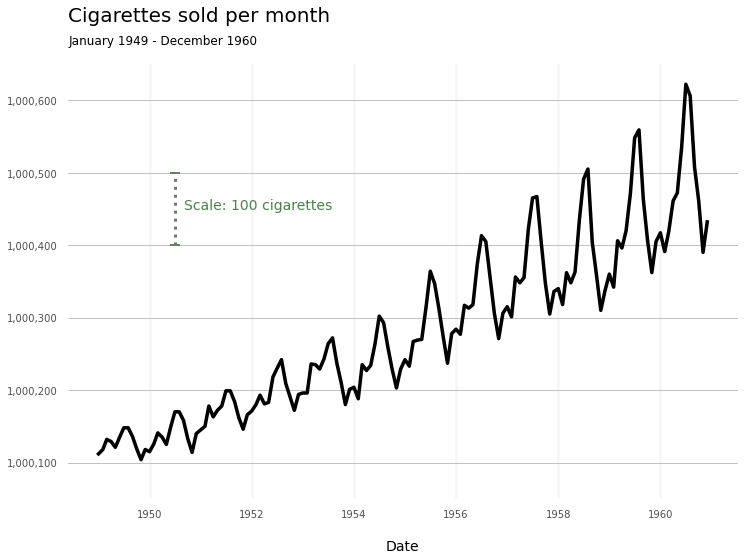

In [16]:
fig, ax = styled_subplots(1, 1, figsize=(12, 8));
ax.plot(y.index, y.values, c='black', lw=3.5)
ax.set_xlabel('Date', labelpad=20, fontsize=14)
ax.set_title(f'{dt_range_str.replace("to","-")}', pad=20, x=0.142);
ax.plot(
    [y.index[18], y.index[18]], [1000400, 1000500], lw=3, ls=':',
    marker='_', ms=10, markeredgewidth=2, color=[0.4, 0.5, 0.4]
)
ax.set_ylim([1000050, 1000650])
ax.set_yticks(list(ax.get_yticks()[1:-1]), [f'{_:,.0f}' for _ in ax.get_yticks()[1:-1]])
ax.text(y.index[20], 1000450, 'Scale: 100 cigarettes',
        color=[0.3, 0.5, 0.3], fontsize=14);
sup_x = fig.subplotpars.left
fig.suptitle('Cigarettes sold per month', fontsize=20, x=sup_x, ha='left');

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Plot the same data on a scale that reflects the relative change in cigarettes sold per month.
</div>

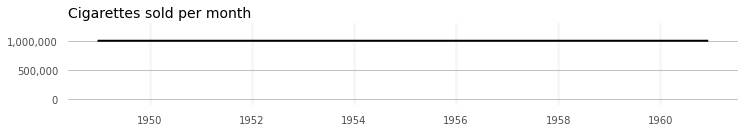

In [17]:
fig, ax = styled_subplots(1, 1, figsize=(12, 1.5))
ax.plot(y.index, y.values, lw=2, color='black')
ax.set_ylim([-100000, y.max() * 1.3])
ax.set_yticks([0, 10**6/2, 10**6], ['0', '500,000','1,000,000'])
ax.set_title('Cigarettes sold per month', loc='left', x=0, fontsize=14);

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

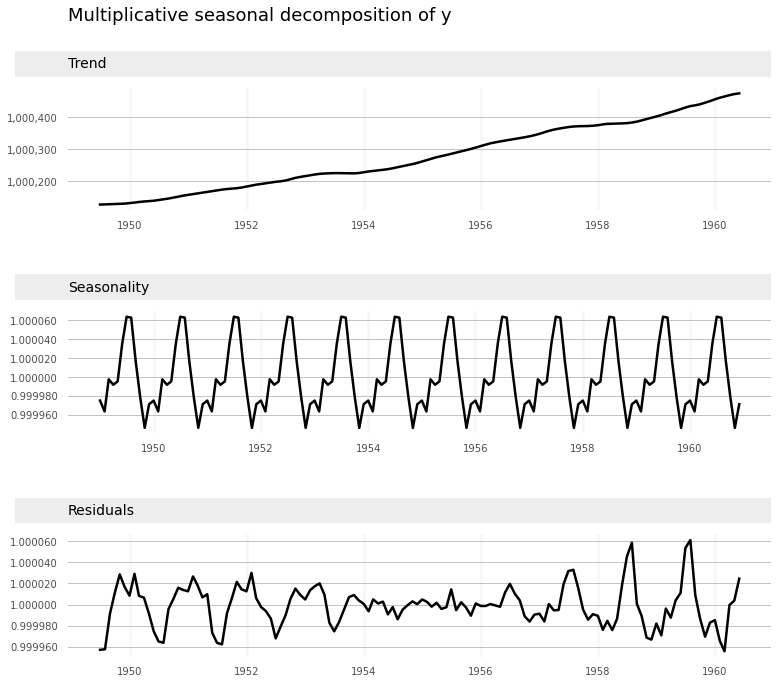

In [18]:
y_mul_decomp = sm.tsa.seasonal_decompose(y.copy(), model='multiplicative')
y_md_seasonal, y_md_trend, y_md_resid = (
    (data, title, params) for data, title, params in zip(
        [y_mul_decomp.seasonal, y_mul_decomp.trend, y_mul_decomp.resid],
        ['Seasonality', 'Trend', 'Residuals'], 
        [{'color': 'black', 'lw': 2.5}] * 3
    )
)
# Plot the original data, the trend, the seasonality, and the residuals 
fig, axs = styled_subplots(3, 1, figsize=(12, 10))
for ax, (data, title, params) in zip(axs.flat, [y_md_trend, y_md_seasonal, y_md_resid]):
    ax.plot(data, **params);
    ax.set_title(title, pad=20, x=0, loc='left', fontsize=14)
    yticks = ax.get_yticks()
    if all(np.round(yticks) == yticks):
        yticks = [yticks, [f'{_:,.0f}' for _ in yticks]]
    else:
        yticks = [yticks, [f'{_:,f}' for _ in yticks]]
    ax.set_yticks(yticks[0][1:-1], yticks[1][1:-1])
fig.tight_layout(pad=5); sup_x = fig.subplotpars.left
fig.suptitle(
    'Multiplicative seasonal decomposition of y', horizontalalignment='left',
    x=sup_x, fontsize=18, y=1
)
for ax in axs:
    titlebox = Rectangle(
        xy=[-0.075, 1.09], width=1.075, height=0.21, visible=True, 
        facecolor=[0.93, 0.93, 0.93], transform=ax.transAxes, clip_on=False
    )
    ax.add_artist(titlebox)
plt.show();

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [19]:
kpss_y = kpss_result(y)
print(kpss_as_str(kpss_y))

InterpolationWarning (statsmodels\tsa\stattools.py)
    The test statistic is outside of the range of p-values available in the
    look-up table. The actual p-value is smaller than the p-value returned.
    
KPSS test results:
-
test statistic          1.6513
p-value <               0.0100*
lags                    8.0000
critical values     
    10.0 %              0.3470
     5.0 %              0.4630
     2.5 %              0.5740
     1.0 %              0.7390


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

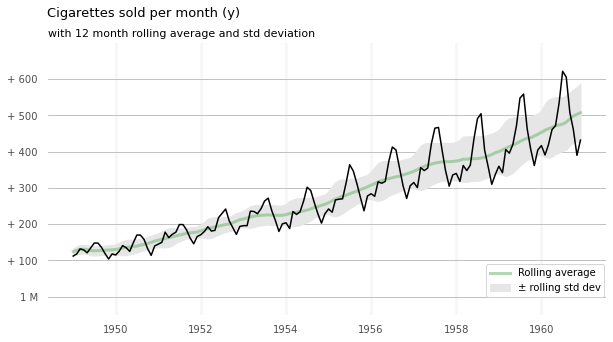

In [20]:
fig, ax = styled_subplots(1, 1, figsize=(10, 5))
ax.plot(y, 'black', lw=1.5, zorder=3)
fig.suptitle(f'Cigarettes sold per month (y)',
             fontsize=13, horizontalalignment='left', x=0.124)
ax.set_title('with 12 month rolling average and std deviation', loc='left', x=0, fontsize=11)
ax.set_ylim(1000000 - 50, 1000700)
ax.set_yticks(ax.get_yticks()[1:-1], 
              ['1 M'] + [f'+ {_}' for _ in range(100, 700, 100)])
y_12mo_std = cont_window_agg(y.values, 12, np.std)
y_12mo_avg = cont_window_agg(y.values, 12, np.mean)
y_lo, y_hi = y_12mo_avg - y_12mo_std, y_12mo_avg + y_12mo_std
ax.plot(y.index, y_12mo_avg, lw=3, zorder=2, alpha=0.5, 
        color=[0.4, 0.7, 0.4], label='Rolling average')
ax.fill_between(y.index, y_lo, y_hi, color=[0.9]*3, zorder=1, 
                label='± rolling std dev')
fig.legend(loc='upper right', bbox_to_anchor=[0.905, 0.28]);

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [21]:
ln_y = np.log(y.copy())

When you plot this, you can see how the variance in our data now remains contant over time.

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Excepting unit scale, y axis labels, and titles, the plot of
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        y
    </span>
    and that of its log transform are indistinguishable.<br><br>
    Plotting <span sytle='font-family:monospace'>ln(y)</span> in isolation is not particularly illustrative. See the figure below.
</div>

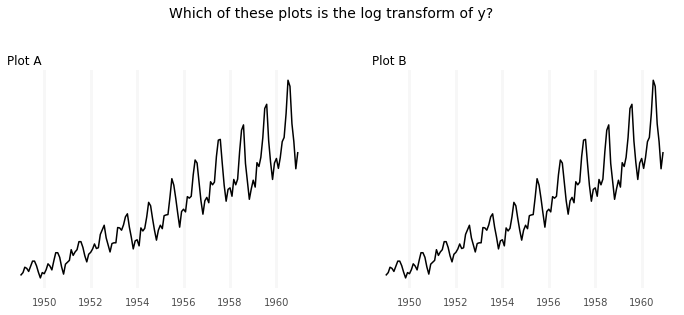

In [22]:
fig, axs = styled_subplots(1, 2, figsize=(12, 4))
for ax, data, title in zip(axs.flat, [ln_y, y], ['Plot A', 'Plot B']):
    ax.plot(data, color='black'); ax.set_title(title, loc='left', x=0)
    ax.set_yticks([])
fig.suptitle('Which of these plots is the log transform of y?', fontsize=14, y=1.1);

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    <a id='array_z'></a>Create a tranformation
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        z
    </span>
    to further reduce the heteroscedasticity of sales data. Assign constants and transformers to variables to facilitate inverse transformations of model predictions.
</div>

z = ln(std_scaled(y) - min(std_scaled(y)) + 1)


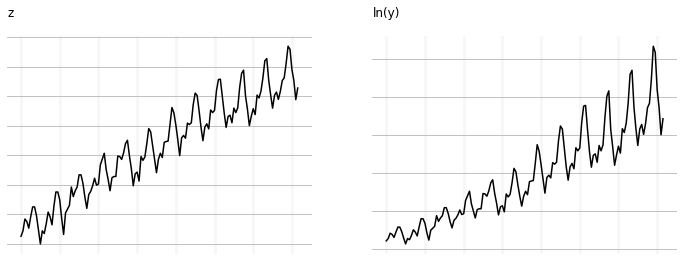

In [23]:
z_scaler = StandardScaler()
y_scaled = z_scaler.fit_transform(y.copy().values.reshape(-1, 1)).reshape(-1)
z_min = y_scaled.min()
y_scaled = y_scaled - z_min + 1
ln_y_scaled = np.log(y_scaled)
z = pd.Series(ln_y_scaled, y.index)
fig, axs = styled_subplots(1, 2, figsize=(12, 4))
for ax, data, title in zip(axs.flat, [ln_y_scaled, ln_y.values], 
                           ['z', 'ln(y)']):
    ax.plot(data, 'black'); ax.set_title(title, loc='left', x=0, pad=20); 
    ax.set_xticks(ax.get_xticks()[1:-1], []), ax.set_yticks(ax.get_yticks()[1:-1], []);
print('z = ln(std_scaled(y) - min(std_scaled(y)) + 1)')

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [24]:
ln_y_1st_diff = pd.Series(np.diff(ln_y), ln_y.index[1:])
ln_y_1st_diff_kpss = kpss_result(ln_y_1st_diff)
print(kpss_as_str(ln_y_1st_diff_kpss))

InterpolationWarning (statsmodels\tsa\stattools.py)
    The test statistic is outside of the range of p-values available in the
    look-up table. The actual p-value is greater than the p-value returned.
    
KPSS test results:
-
test statistic          0.0239
p-value >               0.1000*
lags                    7.0000
critical values     
    10.0 %              0.3470
     5.0 %              0.4630
     2.5 %              0.5740
     1.0 %              0.7390


In [25]:
supposedly_stationarized_y = ln_y_1st_diff.copy()

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

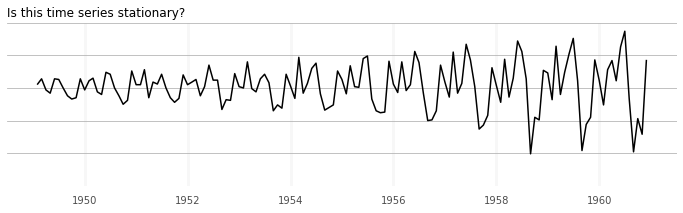

In [26]:
fig, ax = styled_subplots(1, 1, figsize=(12, 3))
ax.plot(supposedly_stationarized_y , color='black')
ax.set_title('Is this time series stationary?', x=0, loc='left')
ax.set_yticks(ax.get_yticks(), ['' for _ in ax.get_yticks()]);

<div style='padding:10px;background-color:rgb(235, 240, 235);'>Among other issues, the plot above exhibits an obvious seasonal trend. Plot the first seasonal difference of 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        ln(y)</span> to determine whether additional differencing may be necessary.
</div>

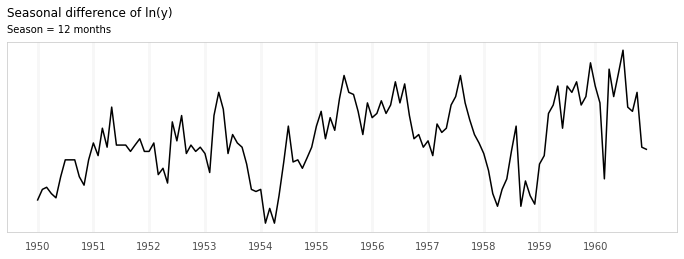

In [27]:
s_diff_ln_y = ln_y.diff(12)[12:]
fig, ax = styled_subplots(1, 1, figsize=(12, 3.5))
ax.plot(s_diff_ln_y, color='black')
ax.set_title('Seasonal difference of ln(y)', loc='left', x=0, pad=25)
ax.set_xticks(y.index[y.index.month==1][1:], y.index[y.index.month==1][1:].year);
ax.set_yticks([]); ax.spines[:].set_color((0.8, 0.8, 0.8))
ax.text(0, 1.05, 'Season = 12 months', ha='left', transform=ax.transAxes);

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    The plot above appears to be a random walk. An optimal model may invovle both seasonal and non-seasonal differencing. 
    <br><br>Plot the first difference of the seasonal difference of 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        ln(y)
    </span>
    to evaluate residuals.
</div>

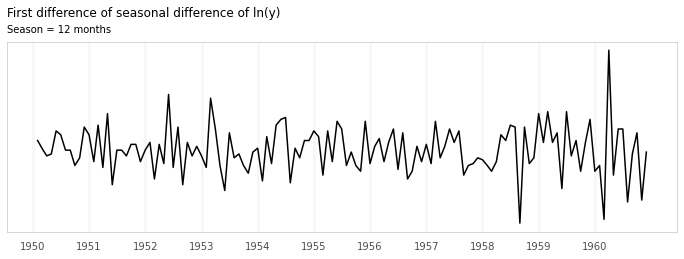

In [28]:
diff_s_diff_ln_y = s_diff_ln_y.diff()[1:]
fig, ax = styled_subplots(1, 1, figsize=(12, 3.5))
ax.plot(diff_s_diff_ln_y , color='black')
ax.set_title('First difference of seasonal difference of ln(y)', loc='left', x=0, pad=25)
ax.set_xticks(y.index[y.index.month==1][1:], y.index[y.index.month==1][1:].year);
ax.set_yticks([]); ax.spines[:].set_color((0.8, 0.8, 0.8))
ax.text(0, 1.05, 'Season = 12 months', ha='left', transform=ax.transAxes);

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    The plot above more closely resembles uncorrelated noise. The log transform of <span style='font-family:monospace;color:rgb(0, 100, 0)'>y</span> may be a seasonal random trend model. This plot also reveals a consistent oscillation resmembling a sine wave with a period of 6 months. The seasonal component of this time series may be easily modeled by sklearn's <span style='font-family:monospace;color:rgb(0, 100, 0)'>GaussianProcessRegressor</span> using their <span style='font-family:monospace;color:rgb(0, 100, 0)'>ExpSineSquared</span> kernel and a period of 12 months.
    <br><br>Plot the seasonal autocorrelation and partial autocorrelation functions of <span style='font-family:monospace;color:rgb(0, 100, 0)'>ln(y)</span> to estimate seasonal order parameters.
</div>

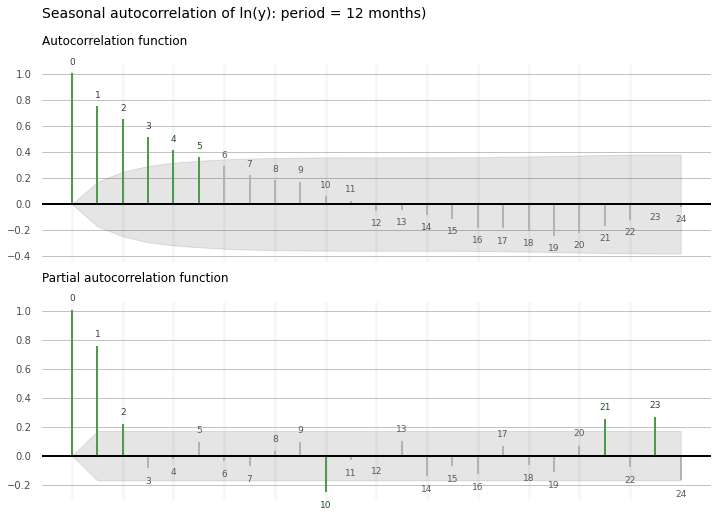

In [29]:
acf_plots(ln_y.diff(12)[12:], suptitle='Seasonal autocorrelation of ln(y): period = 12 months)')

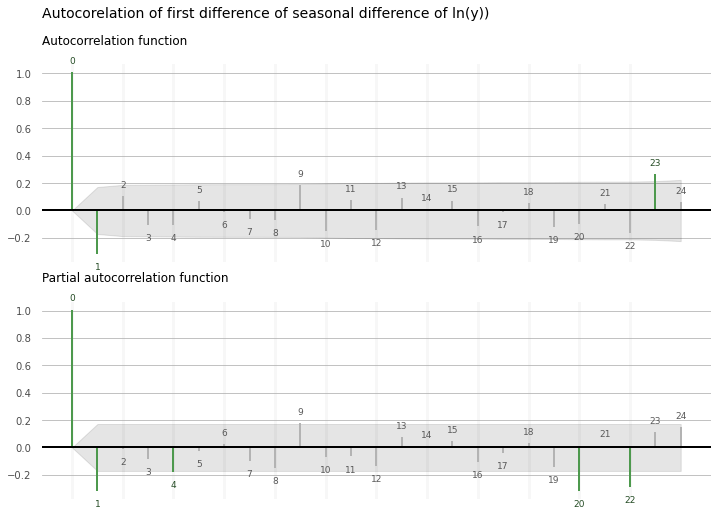

In [30]:
acf_plots(ln_y.diff(12)[12:].diff()[1:],
          suptitle='Autocorelation of first difference of seasonal difference of ln(y))')

# 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    The <span style='font-family:monospace'>statsmodels.tsa.arima_model</span> module is deprecated. The import block formerly placed here has been relocated and rewritten as follows: 
    <br>&emsp;
    <span style='font-family:monospace;color:rgb(50,120,50)'>
        <b>from</b> 
    </span>
    <span style='font-family:monospace'>
        statsmodels.tsa.arima.model
    </span>
    <span style='font-family:monospace;color:rgb(50,120,50)'>
        <b>import</b> 
    </span>
    <span style='font-family:monospace'>
        ARIMA
    </span>
    <br>&emsp;
    <span style='font-family:monospace;color:rgb(50,120,50)'>
        <b>from</b> 
    </span>
    <span style='font-family:monospace'>
        statsmodels.tsa.statespace.sarimax
    </span>
    <span style='font-family:monospace;color:rgb(50,120,50)'>
        <b>import</b> 
    </span>
    <span style='font-family:monospace'>
        SARIMAX
    </span>
    <br><br>
    These and other import statements have been consolidated in section 1a of this notebook.
</div>

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [31]:
def function_to_find_the_mse_of_a_single_arima_model(
        model_results: SARIMAXResults) ->float:
    '''Return the MSE of in sample predictions rendered by a model.
    '''
    return model_results.mse
def arima_mse_cv(model_results: SARIMAXResults, test: ArrayLike) -> float:
    '''Return the MSE of a given fitted model and test array.
    '''
    return mean_squared_error(test, model_results.forecast(len(test)))

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    The model evaluation function written in the cell below uses the <span style='font-family:monospace'>SARIMAXParams</span>, <span style='font-family:monospace'>TimeSeriesModel</span>, and <span style='font-family:monospace'>SARIMAXCrossValResults</span> dataclasses imported from the <span style='font-family:monospace'>sb_dstc_21_1_2.py</span> module. For reference, this module's contents are presented as code cells in a <a href='21.1.2 - Constants%2C classes and functions.ipynb', style='color:rgb(0,0,0);text-decoration: underline'>separate notebook</a>.
</div> 

In [32]:
def sarimax_gs_cv(
        time_series: ArrayLike, p: list[int], d: list[int], 
        q: list[int], P: list[int]=None, D: list[int]=None, Q: list[int]=None, 
        s: list[int]=None) -> SARIMAXCrossValResults:
    '''Perform a grid search of given time series modelling parameters using
    a given time series. Return a results object organizing models by their
    performance across a variety of metrics.
    '''
    pdq_list = [tuple(_) for _ in product(*[p, d, q])]
    if P is None:
        pdq_PDQs = [[_, None] for _ in pdq_list]
    else:
        PDQs_list = [list(_) for _ in product(*[P, D, Q, s])]
        pdq_PDQs = [[pdq, PDQs] for pdq in pdq_list for PDQs in PDQs_list]
    model_params = [SARIMAXParams(_) for _ in pdq_PDQs]
    return SARIMAXCrossValResults(
        [TimeSeriesModel(time_series, params) for params in model_params],
        time_series
    )

In [33]:
# Now, we choose a couple of values to try for each parameter.
p, d, q = [list(range(3)), [0, 1], list(range(3))]
P, D, Q, s = [list(range(3)), [0, 1], list(range(3))] + [[12]]

In [34]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
arima_gs_ln_y = sarimax_gs_cv(ln_y, p, d, q)
sarima_gs_ln_y = sarimax_gs_cv(ln_y, p, d, q, P, D, Q, s)
arima_gs_z = sarimax_gs_cv(z, p, d, q)
sarima_gs_z = sarimax_gs_cv(z, p, d, q, P, D, Q, s)

In [35]:
gs_results = [(arima_gs_ln_y, sarima_gs_ln_y), (arima_gs_z, sarima_gs_z)]

In [36]:
input_arrays = ['ln(y)', 'z']
for (ari, sari), arr_name in zip(gs_results, input_arrays):
    print(f'{"-"*60}\n{arr_name}\n{"-"*60}')
    a_aic, sr_aic = [
        f'{"Best by AIC:":<24}{m.by_aic[0].model_type}\n'
        +f'{"MSE:":<24}{m.by_aic[0].mse}' for m in [ari, sari]
    ]
    print('\n-\n'.join([ari.report(), a_aic, sari.report(), sr_aic])+'\n-')
print(f'{"-"*60}\n-')

------------------------------------------------------------
ln(y)
------------------------------------------------------------
ARIMA model cv results:
Models tested:          18
Best model:             ARIMA(0, 1, 2)
Metric                  Mean squared error (MSE)
MSE:                    6.154201067867238e-09
MSE / s²:               1.0090806597282769
MSE / X̄(test):          4.4544173405458327e-10
-
Best by AIC:            ARIMA(1, 0, 1)
MSE:                    1.8010928280960268e-08
-
SARIMA model cv results:
Models tested:          321
Best model:             SARIMA(1, 1, 0)x[2, 0, 1]₁₂
Metric                  Mean squared error (MSE)
MSE:                    5.636184096414592e-09
MSE / s²:               0.9241434109222298
MSE / X̄(test):          4.0794761004255516e-10
-
Best by AIC:            SARIMA(2, 1, 1)x[0, 0, 1]₁₂
MSE:                    9.361717102152879e-09
-
------------------------------------------------------------
z
--------------------------------------------------

So the best p,d, q, parameters for our ARIMA model are 
<span style='color:rgb(150, 0, 0)'>
    2, 1, 1
</span>
respectively. Now we know this, we can build the model.

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    None of the tested array transforms and modelling methods returned 2, 1, and 1 as the best p, d, and q parameters for an ARIMA model as indicated by mean squared error performance during cross validation (given a single split and test size as defined in lower tier notebooks). <br><br>
    For non-seasonal ARIMA models, AIC scores favored these parameter values only for the log transform of the scaled, centered, and offset sales data assigned to the variable 
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        z</span>. <br><br>For SARIMA models, the order parameters (2, 1, 1) performed best only when also specifying seasonal order parameters of (0, 0, 1)₁₂ and (1, 0, 1)₁₂ for the input arrays
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        ln_y
    </span> and <span style='font-family:monospace;color:rgb(0, 100, 0)'>z</span>, respectively.    
</div>

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    The majority of remaining tasks in this notebook are performed using the SARIMA model developed using the
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        z
    </span> transformation of <span style='font-family:monospace;color:rgb(0, 100, 0)'>y</span> and the order parameters found using the grid search performed above.
</div>

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Generate models using the best parameters found during grid searches.
</div>

In [37]:
with warnings.catch_warnings(record=True) as w:
    ln_y_sarima = SARIMAX(ln_y, order=(1, 1, 0), seasonal_order=(2, 0, 1, 12))
    ln_y_res = ln_y_sarima.fit()
    z_params = sarima_gs_z.by_aic[0].params
    z_model = SARIMAX(z, order=z_params.order, seasonal_order=z_params.seasonal_order)
    z_res = z_model.fit()

We can take a look at a summary of the model this library has built around our data.

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Print summaries of models fit to order parameters found using the grid search performed above.
</div>

In [38]:
print('input array: ln(y)')
ln_y_res.summary()

input array: ln(y)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                sales   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(2, 0, [1], 12)   Log Likelihood                1230.227
Date:                              Fri, 28 Oct 2022   AIC                          -2450.454
Time:                                      21:21:05   BIC                          -2435.639
Sample:                                  01-01-1949   HQIC                         -2444.434
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3086   7.13e-19   4.33e+17      0.000       0.309       0.309
ar.S.L12           -0   2.09e-19         -0      1.000    -4.1e-19     4.1e-19
ar.S.L24            0   3.03e-19          0      1.000   -5.94e-19    5.94e-19
ma.S.L12      -0.3871   3.76e-19  -1.03e+18      0.000      -0.387      -0.387
sigma2      1.036e-09   1.86e-10      5.576      0.000    6.72e-10     1.4e-09
===================================================================================
Ljung-Box (L1) (Q):                   4.23   Jarque-Bera (JB):                11.81
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):              10.12   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.57e+33. Standard errors may be unstable.
"""

In [39]:
print('input array: log transform of scaled, centered, and offset y ("z")')
z_res.summary()

input array: log transform of scaled, centered, and offset y ("z")


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 265.644
Date:                            Fri, 28 Oct 2022   AIC                           -519.288
Time:                                    21:21:05   BIC                           -501.511
Sample:                                01-01-1949   HQIC                          -512.064
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5879      0.102      5.761      0.000       0.388       0.788
ar.L2          0.1998      0.087      2.299      0.022       0.029       0.370
ma.L1         -0.9487      0.059    -16.103      0.000      -1.064      -0.833
ar.S.L12       0.9892      0.009    109.612      0.000       0.972       1.007
ma.S.L12      -0.5424      0.114     -4.758      0.000      -0.766      -0.319
sigma2         0.0011      0.000      8.576      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.61
Prob(Q):                              0.93   Prob(JB):                         0.10
Heteroskedasticity (H):               0.71   Skew:                             0.06
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Generate predictions and print a summary using a model fit to
    <span style='font-family:monospace;color:rgb(0, 100, 0)'>
        z
    </span>
     with the order parameters found using the grid search performed above. Perform the inverse transformations required to allow comparison of predictions with observed values.
</div>

In [40]:
z_pred = z_res.predict(0, len(y) + 120)
z_exp = np.exp(z_pred)
z_inv_constants = z_exp + z_min - 1
z_y = z_scaler.inverse_transform(z_inv_constants.values.reshape(-1, 1)).reshape(-1)[1:]

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Plot predictions against original data.
</div>

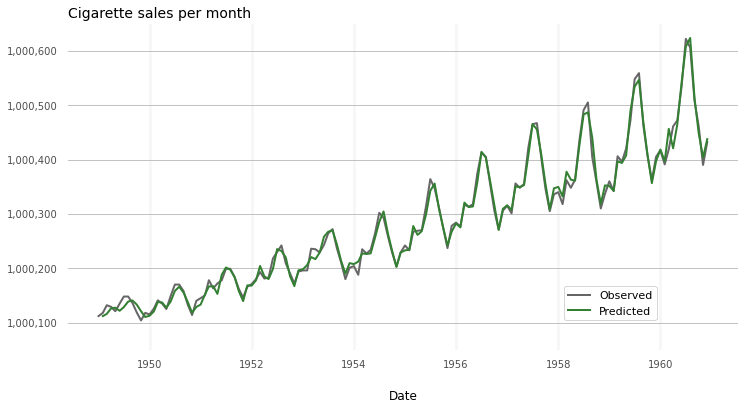

In [41]:
z_y_dt = pd.Series(z_y[:len(y) - 1], index=y.index[1:])
fig, ax = styled_subplots(1, 1, figsize=(12, 6))
labels = ['Observed', 'Predicted']
colors = [(0.4, 0.4, 0.4), (0.2, 0.5, 0.2)]
for data, label, color in zip([y, z_y_dt], labels, colors):
    ax.plot(data, color=color, label=label, lw=2)
fig.legend(loc='upper right', bbox_to_anchor=[0.8125, 0.285], fontsize=11)
ax.set_title('Cigarette sales per month', loc='left', x=0, fontsize=14)
ax.set_ylim([1000050, 1000650])
ax.set_yticks(list(ax.get_yticks()[1:-1]), [f'{_:,.0f}' for _ in ax.get_yticks()[1:-1]])
ax.set_xlabel('Date', labelpad=20, fontsize=12);

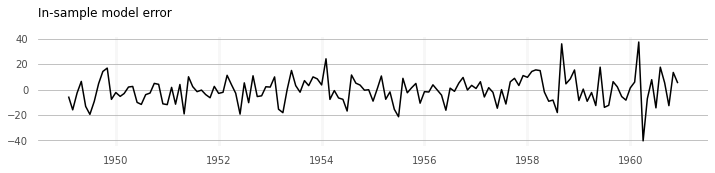

In [42]:
model_error = z_y_dt - y.values[1:]
fig, ax = styled_subplots(1, 1, figsize=(12, 2))
ax.plot(model_error, 'black')
ax.set_title('In-sample model error', x=0, loc='left', pad=20);

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Plot interpolated in-sample model error; encode error sign as color.
</div>

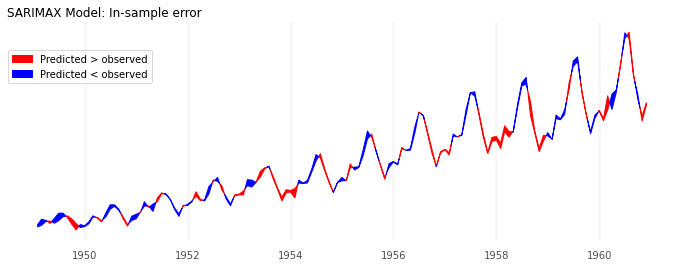

In [43]:
fig, ax = styled_subplots(1, 1, figsize=(12, 4))
ax.fill_between(y.index[1:], z_y_dt, y.values[1:], interpolate=True, color='r',
                where=model_error > 0, label='Predicted > observed')
ax.fill_between(y.index[1:], z_y_dt, y.values[1:], interpolate=True, color='b', 
                where=model_error < 0, label='Predicted < observed')
ax.set_yticks([])
ax.set_title('SARIMAX Model: In-sample error', loc='left', x=0);
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.8));

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [44]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 120
forecast_dt_ind = pd.DatetimeIndex(
    pd.date_range(y.index[0], periods=len(y) + forecast_period, freq=y.index.freqstr)
)
# Convert that range into a dataframe that includes your predictions
predictions = pd.DataFrame(
    {'sales': z_y},
    index=forecast_dt_ind
)
print(f'predictions index:\n{forecast_dt_ind}')
print('-\npredictions DataFrame sample:')
predictions.head(3)

predictions index:
DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1970-03-01', '1970-04-01', '1970-05-01', '1970-06-01',
               '1970-07-01', '1970-08-01', '1970-09-01', '1970-10-01',
               '1970-11-01', '1970-12-01'],
              dtype='datetime64[ns]', length=264, freq='MS')
-
predictions DataFrame sample:


,sales
1949-01-01,1.000112e+06
1949-02-01,1.000116e+06
1949-03-01,1.000126e+06


<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    For comparison, generate a 120 month forecast using an <span style='font-family:monospace'>ARIMA(2, 1, 1)</span> model as recommended by this notebook's instructional text. Supply relevant values to the trend argument. Perform inverse transformations as above.
</div>

In [45]:
with warnings.catch_warnings(record=True) as w:
    arima_211 = ARIMA(ln_y, order=(2, 1, 2), trend=[0, 0, 1]).fit().get_forecast(120)
    arima_211_pm = arima_211.predicted_mean
    arima_211_y = pd.Series(np.exp(arima_211_pm.values), index=arima_211_pm.index)

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Plot the predicted changes in cigarette sales between 1961 and 1970.
</div>

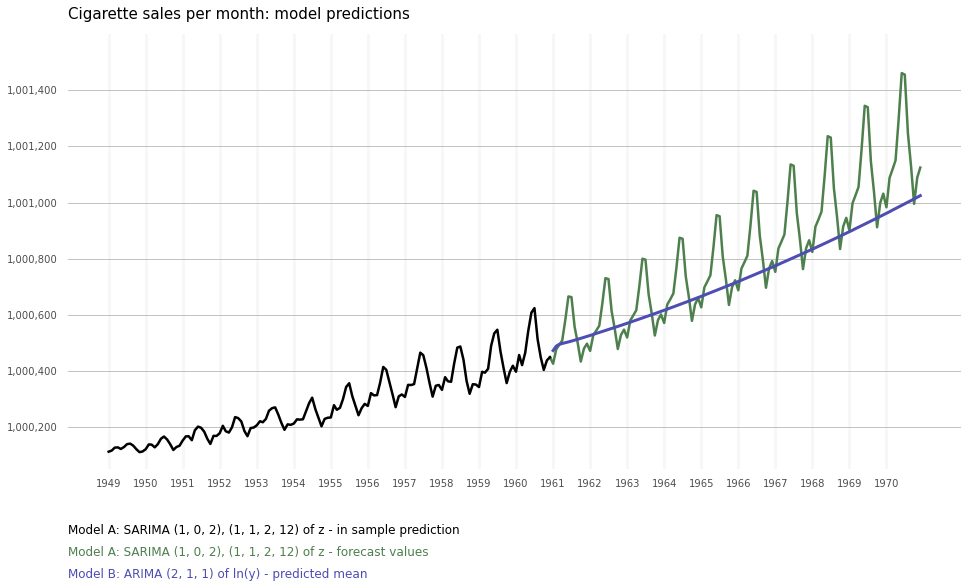

In [46]:
# Plot your future predictions
fig, ax = styled_subplots(1, 1, figsize=(16, 8))
ax.plot(predictions.iloc[:len(y)], label='In sample prediction', zorder=3,
        color=('black'), lw=2.5)
ax.plot(predictions.iloc[len(y) - 1:], label='Out of sample model (A*)', zorder=2,
        color=[0.3, 0.5, 0.3], lw=2.5)
ax.set_title('Cigarette sales per month: model predictions', loc='left', x=0, fontsize=15, pad=15)
ax.set_ylim([1000050, 1001600])
ax.set_yticks(list(ax.get_yticks()[1:-1]), [f'{_:,.0f}' for _ in ax.get_yticks()[1:-1]]);
ax.set_xticks(predictions.index[predictions.index.month==1], 
              predictions.index[predictions.index.month==1].year);
ax.plot(arima_211_y, lw=3, label='Predicted mean (B*)', color=[0.3, 0.3, 0.7])
#fig.legend(loc='lower left', bbox_to_anchor=(0.7, 0.175), fontsize=11);
ax.text(0, -0.15, 'Model A: SARIMA (1, 0, 2), (1, 1, 2, 12) of z - in sample prediction',
        transform=ax.transAxes, fontsize=12)
ax.text(0, -0.2, 'Model A: SARIMA (1, 0, 2), (1, 1, 2, 12) of z - forecast values', transform=ax.transAxes, 
        fontsize=12, color=[0.3, 0.5, 0.3])
ax.text(0, -0.25, 'Model B: ARIMA (2, 1, 1) of ln(y) - predicted mean', transform=ax.transAxes, 
        fontsize=12, color=[0.3, 0.3, 0.7]);

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Plot the same data over y coordinates that better describe relative change.
</div>

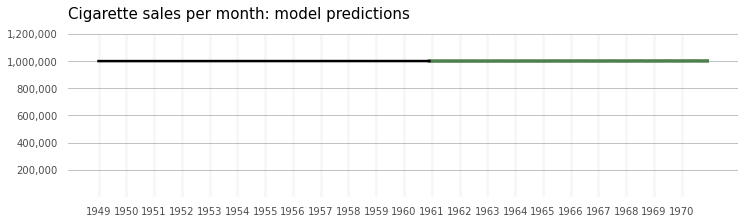

In [47]:
# Plot your future predictions
fig, ax = styled_subplots(1, 1, figsize=(12, 3))
ax.plot(predictions.iloc[:len(y)], label='In sample prediction', zorder=3,
        color=('black'), lw=2.5)
ax.plot(predictions.iloc[len(y) - 1:], label='Out of sample model (A*)', zorder=2,
        color=[0.3, 0.5, 0.3], lw=3.5)
ax.set_title('Cigarette sales per month: model predictions', loc='left', x=0, fontsize=15, pad=15)
ax.set_ylim([0, ax.get_ylim()[1] * 1.2])
ax.set_yticks(list(ax.get_yticks()[1:-1]), [f'{_:,.0f}' for _ in ax.get_yticks()[1:-1]]);
ax.set_xticks(predictions.index[predictions.index.month==1], 
              predictions.index[predictions.index.month==1].year);

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Cowboy Cigarette sales did not increase much over the 10 years covered by this dataset. Measured from the minimum observed value to the maximum predicted value, cigarettes sales would have increased by less than 1% (nearly an order of magnitude less than 1%) over a period of 21 years (see calculation below). The changes in cigarette sales over time are only remarkable for consistently exhibiting multiplicative seasonality over an extremely narrow range of absolute changes in monthly sales.
</div>

In [48]:
print(f'maximum sales increase: {float((predictions.max() - y.min()) / y.min() * 100):>5.3f} %')

maximum sales increase: 0.136 %


<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    Plot each model prediction as an expression of growth since 1949.<br><br>
    The upper bound of the y-axis in the plot below is set at a 1% increase in monthly sales since January of 1949.
</div>

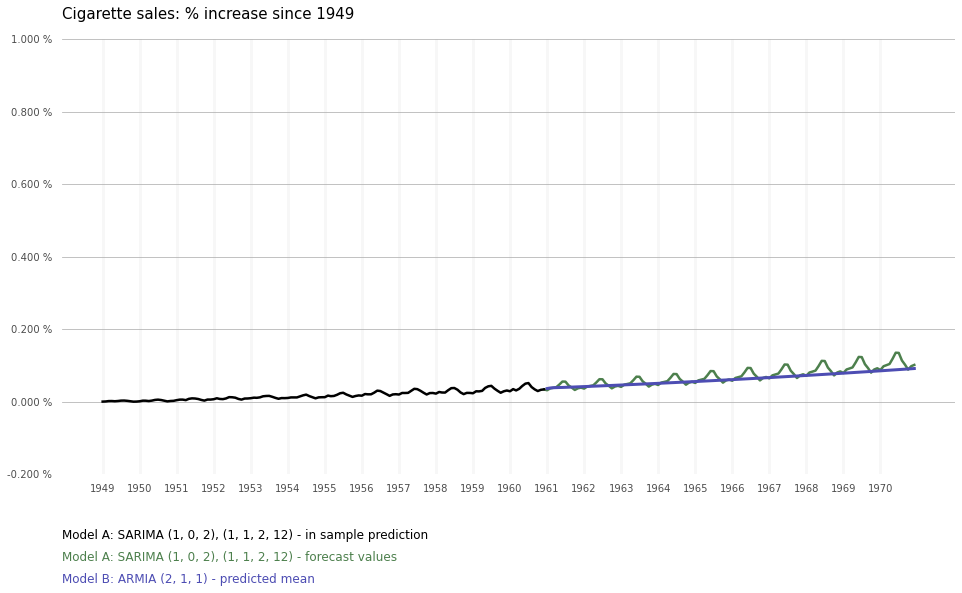

In [49]:
fig, ax = styled_subplots(1, 1, figsize=(16, 8))
ax.plot(predictions.iloc[:len(y)] / y[0], label='In sample prediction', zorder=3,
        color=('black'), lw=2.5)
ax.plot(predictions.iloc[len(y) - 1:] / y[0], label='Out of sample model (A*)', zorder=2,
        color=[0.3, 0.5, 0.3], lw=2.5)
ax.set_title('Cigarette sales: % increase since 1949', loc='left', x=0, fontsize=15, pad=20)
ax.plot(arima_211_y / y[0], lw=3, label='Predicted mean (B*)', color=[0.3, 0.3, 0.7])
ax.set_ylim(0.9999, 1.01)
ax.set_yticks(ax.get_yticks(), [f'{_:.3f} %' for _ in (np.array(ax.get_yticks()) - 1) * 100])
ax.set_xticks(predictions.index[predictions.index.month==1], 
              predictions.index[predictions.index.month==1].year);
ax.text(0, -0.15, 'Model A: SARIMA (1, 0, 2), (1, 1, 2, 12) - in sample prediction',
        transform=ax.transAxes, fontsize=12)
ax.text(0, -0.2, 'Model A: SARIMA (1, 0, 2), (1, 1, 2, 12) - forecast values', transform=ax.transAxes, 
        fontsize=12, color=[0.3, 0.5, 0.3])
ax.text(0, -0.25, 'Model B: ARMIA (2, 1, 1) - predicted mean', transform=ax.transAxes, 
        fontsize=12, color=[0.3, 0.3, 0.7]);

<div style='padding:10px;background-color:rgb(235, 240, 235);'>
    For context, load US population data from census.gov.¹
    <br><br>
    A text version of this data is available <a href='https://www.census.gov/data/tables/time-series/dec/popchange-data-text.html'; style='color:rgb(0,0,0);text-decoration: underline'><u>here</u></a>. A csv file of the same may be downloaded via <a href='https://www2.census.gov/programs-surveys/decennial/2020/data/apportionment/apportionment.csv'; style='color:rgb(0,0,0);text-decoration: underline'><u>this link</u></a>.
</div>


In [50]:
census_data = pd.read_csv('US_Census_historical_apportionment.csv')
us_population = census_data.loc[census_data.Name=='United States', ['Year', 'Resident Population']]
us_population.rename(columns={'Resident Population':'resident_population', 'Year': 'year'}, inplace=True)
us_population.loc[:, 'resident_population'] = (
    us_population.loc[:, 'resident_population'].str.replace(',', '').astype(int)
)
us_pop_ind = pd.DatetimeIndex(
    us_population.loc[:, 'year'].astype(str)
    .str.replace('(.*)', '\\1-01', regex=True).astype(np.datetime64), freq='infer'
)
us_pop_by_mo = us_population.set_index(us_pop_ind).drop(columns='year').resample('MS').interpolate()
us_pop_49_71 = us_pop_by_mo.loc[us_pop_by_mo.index.year.isin(range(1949, 1971))].resident_population

<div style='padding:10px;background-color:rgb(235, 240, 235);'>To provide additional context, construct an array of United States cigarette consumption data for the period relevant to this business problem as published by the USDA Economic Research Service³.<br><br>
This report provides estimated annual cigarette conumption in billion cigarettes consumed. Transform this data into monthly estimates by reindexing, interpolating, and performing the required multiplication and division.</div>

In [51]:
us_cig_consumption = {
    1949: 351.8, 1950: 375.8, 1951: 399.8, 1952: 415.8, 1953: 405.6,
    1954: 384.6, 1955: 395.3, 1956: 406.6, 1957: 423.1, 1958: 449.8,
    1959: 467.4, 1960: 484.4, 1961: 502.7, 1962: 508.4, 1963: 523.9,
    1964: 511.2, 1965: 528.7, 1966: 541.2, 1967: 549.2, 1968: 545.7,
    1969: 528.9, 1970: 536.4
}
us_cig_consumption = dict(zip(
    ['year', 'billion_units_consumed'], (zip(*us_cig_consumption.items()))
))
us_cig_consumption['year'] = pd.to_datetime([f'{yyyy}-01-01' for yyyy in us_cig_consumption['year']])
us_cig_consumption = pd.Series(
    us_cig_consumption['billion_units_consumed'], index=us_cig_consumption['year']
)
us_cig_interp = us_cig_consumption.reindex(predictions.index).interpolate()
cig_consump_b = us_cig_interp * 10** 9
cig_consump_monthly = cig_consump_b / 12
cig_per_capita = cig_consump_b/us_pop_49_71

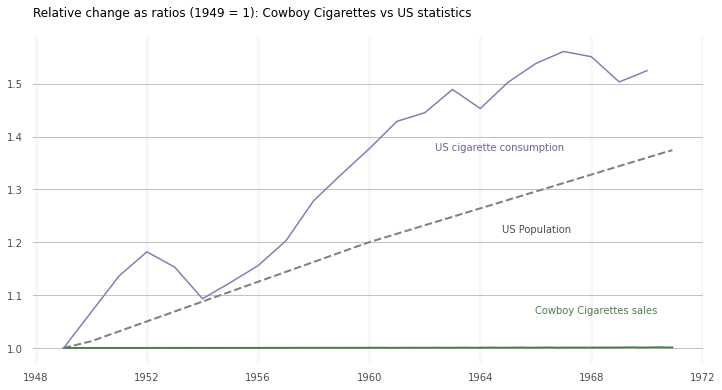

In [52]:
fig, ax = styled_subplots(1, 1, figsize=(12, 6))
us_million_residents = us_pop_49_71.loc[predictions.index] / 1000000
ax.set_title('Relative change as ratios (1949 = 1): Cowboy Cigarettes vs US statistics', loc='left', x=0, pad=20)
ax.plot(us_million_residents / us_million_residents[0], label='US Population', color='gray', lw=2, ls='--')
ax.plot(predictions.index, z_y/z_y[0], label='Cigarettes sold', color=[0.3, 0.5, 0.3], lw=2)
ax.plot(
    us_cig_consumption / us_cig_consumption.values[0], label='Cigarette Consumption', 
    color=[0.5, 0.5, 0.7]
)
#ax.set_ylim(0.975, 1.43)
ax.text(0.75, 0.15, 'Cowboy Cigarettes sales', transform=ax.transAxes, color=[0.3, 0.5, 0.3])
ax.text(0.7, 0.4, 'US Population', transform=ax.transAxes, color=(0.3, 0.3, 0.3))
ax.text(0.6,0.65, 'US cigarette consumption', color=[0.4, 0.4, 0.6], transform=ax.transAxes);

<div style='padding:10px;background-color:rgb(235, 240, 235);'>These comparisons suggest sales of Cowboy Cigarettes account for a shrinking proportion of cigarettes consumed in the United States.

Plot the estimated market share of Cowboy Cigarettes over the same period.</div>

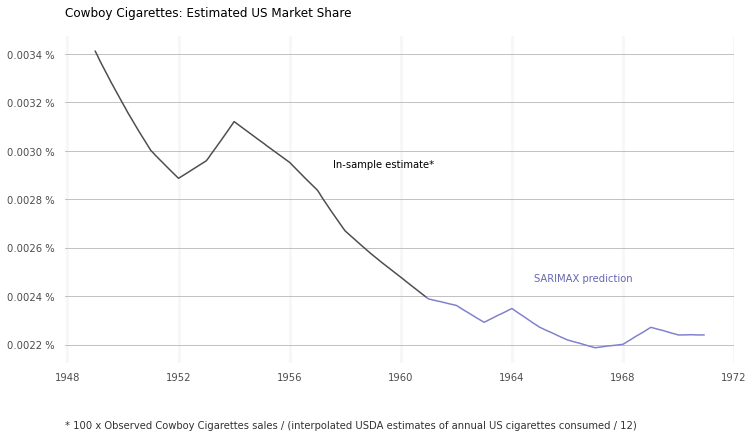

In [53]:
market_share = 100 * predictions.sales / (cig_consump_monthly)
in_sample_share = 100 * y.values / (cig_consump_monthly[y.index])
predicted_share = market_share.iloc[len(y) - 1:]
fig, ax = styled_subplots(1, 1, figsize=(12, 6))
ax.plot(in_sample_share, color=(0.3, 0.3, 0.3), label='In sample estimate*')
ax.plot(predicted_share, color=(0.5, 0.5, 0.8), label='SARIMAX prediction estimate')
ax.text(0, -0.2, '* 100 x Observed Cowboy Cigarettes sales / '
        + '(interpolated USDA estimates of annual US cigarettes consumed / 12)', 
        transform=ax.transAxes, color=(0.2, 0.2, 0.2))
#fig.legend(loc='upper left', bbox_to_anchor=(0.6, 0.705), frameon=False)
ax.set_title('Cowboy Cigarettes: Estimated US Market Share', x=0, loc='left', pad=20)
ax.set_yticks(ax.get_yticks()[1:-1], [f'{_:.4f} %' for _ in ax.get_yticks()[1:-1]])
ax.text(0.7, 0.25, 'SARIMAX prediction', transform=ax.transAxes, ha='left', color=(0.4, 0.4, 0.7))
ax.text(0.4, 0.6, 'In-sample estimate*', transform=ax.transAxes, ha='left');

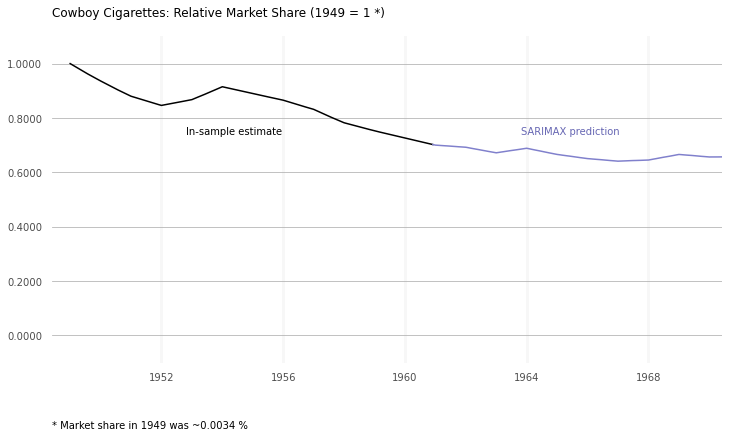

In [54]:
market_share_0 = in_sample_share[0]
in_sample_share_rel = in_sample_share / market_share_0
predicted_share_rel = predicted_share / market_share_0
fig, ax = styled_subplots(1, 1, figsize=(12, 6))
ax.plot(in_sample_share_rel, color='black', label='In sample estimate*')
ax.plot(predicted_share_rel, color=(0.5, 0.5, 0.8), label='SARIMAX prediction estimate')
ax.text(0, -0.2, f'* Market share in 1949 was ~{market_share_0:.4f} %', transform=ax.transAxes)
#fig.legend(loc='upper left', bbox_to_anchor=(0.2, 0.3), frameon=False)
ax.set_title('Cowboy Cigarettes: Relative Market Share (1949 = 1 *)', x=0, loc='left', pad=20);
ax.set_ylim(-0.1, 1.1)
ax.set_yticks(ax.get_yticks()[1:-1], [f'{_:.4f}' for _ in ax.get_yticks()[1:-1]])
ax.text(0.7, 0.7, 'SARIMAX prediction', transform=ax.transAxes, ha='left', color=(0.4, 0.4, 0.7))
ax.text(0.2, 0.7, 'In-sample estimate', transform=ax.transAxes, ha='left');
ax.set_xlim(pd.to_datetime(['1948-06-01', '1970-06-01']));

<div style='padding:10px;background-color:rgb(240, 240, 245);'>
    References<br>&emsp;<br>
    1<br>
    United States Census Bureau. <i>Historical Population Change Data (1910-2020)</i>.<br>
    05 August 2022.<br>
    <a href='https://www.census.gov/data/tables/time-series/dec/popchange-data-text.html'; 
       style='text-decoration:none;color:rgb(20,20,120)'>
        www.census.gov/data/tables/time-series/dec/popchange-data-text.html
    </a><br>
    Website. Accessed 20 October 2022.<br>&emsp;<br>
    2<br>
    United States Census Bureau. <i>Historical Population Change Data (1910-2020)</i>.<br>
    05 August 2022<br>
    <a href='https://www2.census.gov/programs-surveys/decennial/2020/data/apportionment/apportionment.csv',
       style='text-decoration:none;color:rgb(20,20,120)'>
        www2.census.gov/programs-surveys/decennial/2020/data/apportionment/apportionment.csv</a><br>
    CSV file. Acessed 20 October 2022.<br>&emsp;<br>
    3<br>
    Creek, Laverne, et al. <i>U.S. Tobacco Statistics, 1935-92</i>.<br>
    United States Department of Agriculture Economic Research Service Commodity Economics Division Statistical Bulletin Number 869.<br>
    U.S. Department of Agriculture Econonmic Research Service, April 1994.<br>
    <a href='https://www.ers.usda.gov/webdocs/publications/47092/59808_sb869.pdf?v=7361.5', style='text-decoration:none;color:rgb(20,20,120)'>
        www.ers.usda.gov/webdocs/publications/47092/59808_sb869.pdf?v=7361.5</a><br>
    PDF File. Accessed 22 October 2022<br>
</div>    